# Allstate Corporation

## Imports

In [199]:
# data analysis and data wrangling
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier  # enbedded method

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import pprint
import time
import os

## Prepare Principal Directory

In [200]:
def exit_current_directory(end_directory: str='notebooks'):
    # PATH current
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [201]:
exit_current_directory(end_directory='notebooks')

'Current working directory: /home/campos/projetos/challenges/kaggle/allstate-claims-severity'

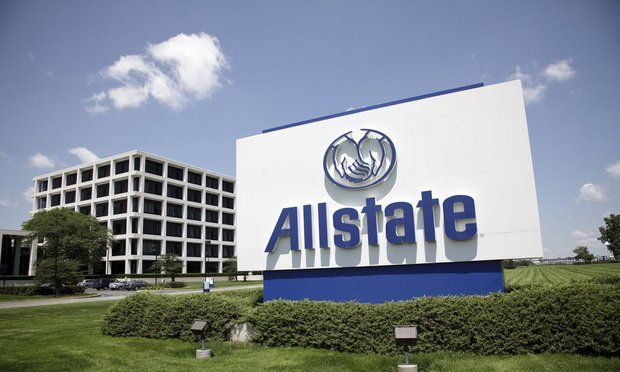

In [202]:
Image(filename="references/images/allstate.jpg",
      format='png',
      url=None,
      width=800,
      height=None,
      unconfined=True,
      metadata=None)

### Prepare Environment

In [203]:
# from <package>.<module> import <class>
from src.environment.prepare_env import *


main()

Requirements this project:

matplotlib==3.1.1
xgboost==0.71
seaborn==0.9.0
numpy==1.16.4
pandas==0.24.2
missingno==0.4.1
ipython==7.6.1
scikit_learn==0.21.2
atlas==0.27.0

--------------------------------------------------
Configuration Environment:

OS:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 19.04
Release:	19.04
Codename:	disco

Python Version:
Python 3.7.3

Pip Version:
pip 19.1.1 from /home/campos/projetos/challenges/kaggle/allstate-claims-severity/src/environment/venv/lib/python3.7/site-packages/pip (python 3.7)

Jupyter Version:
4.4.0

--------------------------------------------------

Disk Usage:

data:
220M	data/

virtual env:
383M	src/environment/venv/

all:
868M	.

--------------------------------------------------
Structure This Project:

.
├── data
│   ├── cleansing
│   │   ├── test.csv
│   │   └── train.csv
│   ├── raw
│   │   ├── sample_submission.csv
│   │   ├── test.csv
│   │   └── train.csv
│   └── submissions-kaggle
│       ├── lin_regression_submission.csv


## Format cell

In [204]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# parametros de config
rc={'savefig.dpi': 500, 
    'figure.autolayout': True, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 15, 
    'lines.linewidth': 1.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 15,
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# pretty print
pp = pprint.PrettyPrinter(indent=4)

### Load dataset

In [205]:
%%time

# load data in dataset
df_train = pd.read_csv("data/raw/train.csv", 
                       encoding='utf-8')
df_test = pd.read_csv("data/raw/test.csv", 
                      encoding='utf-8')

CPU times: user 3.94 s, sys: 200 ms, total: 4.14 s
Wall time: 4.14 s


### Global Variables

In [206]:
# Lists that will be manipulated in the data processing
list_columns = []
list_categorical_col = []
list_numerical_col = []

In [207]:
def get_col(df: 'dataframe', type_descr: 'numpy') -> list:
    """
    Function get list columns 
    
    Args:
    type_descr
        np.number, np.object -> return list with all columns
        np.number            -> return list numerical columns 
        np.object            -> return list object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n')    
    else:
        return col.tolist() 

In [208]:
list_numerical_col = get_col(df=df_train,
                             type_descr=np.number)
list_categorical_col = get_col(df=df_train,
                               type_descr=np.object)
list_columns = get_col(df=df_train,
                       type_descr=[np.object, np.number])

---

## Data Exploration 

#### Datasets
The dataset contains 2 .csv files with information needed to make a forecast. They are::<br/>
1. Variables in train.csv and test.csv: 
 - **id:** the id of a couple of questions from the training set
 - **cat1 to cat116:** category variables (the range of values is not provided, nor the column names).
 - **cont1 to cont14:** continuous variables (the range of values is not provided nor the names of the columns).
 - **loss:** the amount that the company has to pay for a particular claim. This is the target variable.
 
 
 NOTE: In test.csv, the loss is not present, since we will predict this.

In [209]:
# Size and types of the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [210]:
print("Dataframe:\n{} rows\n{} columns"
      .format(df_train.shape[0],
              df_train.shape[1]))

Dataframe:
188318 rows
132 columns


In [211]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


In [212]:
print("Dataframe:\n{} rows\n{} columns"
      .format(df_test.shape[0],
              df_test.shape[1]))

Dataframe:
125546 rows
131 columns


### Data Type
Within _data_ there are 3 types of data: <br/>
- float64(15) = continuos_feature + loss
- int64(1) = id
- object(116) = categorical_feature

In [213]:
df_train.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10 cat11 cat12 cat13  \
0   1    A    B    A    B    A    A    A    A    B     A     B     A     A   
1   2    A    B    A    A    A    A    A    A    B     B     A     A     A   
2   5    A    B    A    A    B    A    A    A    B     B     B     B     B   
3  10    B    B    A    B    A    A    A    A    B     A     A     A     A   
4  11    A    B    A    B    A    A    A    A    B     B     A     B     A   

  cat14 cat15 cat16 cat17 cat18 cat19 cat20 cat21 cat22 cat23 cat24 cat25  \
0     A     A     A     A     A     A     A     A     A     B     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     A     A   
3     A     A     A     A     A     A     A     A     A     B     A     A   
4     A     A     A     A     A     A     A     A     A     B     A     A   

  cat26 cat27 cat28 cat29 cat30 cat31 cat32 cat33 cat34 cat35 cat36 cat37  \
0     A     A     A     A     A     A     A     A     A     A     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     B     A   
3     A     A     A     A     A     A     A     A     A     A     A     A   
4     A     A     A     A     A     A     A     A     A     A     A     A   

  cat38 cat39 cat40 cat41 cat42 cat43 cat44 cat45 cat46 cat47 cat48 cat49  \
0     A     A     A     A     A     A     A     A     A     A     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     A     A   
3     A     A     A     A     A     A     A     A     A     A     A     A   
4     A     A     A     A     A     A     A     A     A     A     A     A   

  cat50 cat51 cat52 cat53 cat54 cat55 cat56 cat57 cat58 cat59 cat60 cat61  \
0     A     A     A     A     A     A     A     A     A     A     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     A     A   
3     A     A     A     A     A     A     A     A     A     A     A     A   
4     A     A     A     A     A     A     A     A     A     A     A     A   

  cat62 cat63 cat64 cat65 cat66 cat67 cat68 cat69 cat70 cat71 cat72 cat73  \
0     A     A     A     A     A     A     A     A     A     A     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     A     A   
3     A     A     A     A     A     A     A     A     A     A     A     B   
4     A     A     A     A     A     A     A     A     A     A     B     A   

  cat74 cat75 cat76 cat77 cat78 cat79 cat80 cat81 cat82 cat83 cat84 cat85  \
0     A     B     A     D     B     B     D     D     B     D     C     B   
1     A     A     A     D     B     B     D     D     A     B     C     B   
2     A     A     A     D     B     B     B     D     B     D     C     B   
3     A     A     A     D     B     B     D     D     D     B     C     B   
4     A     A     A     D     B     D     B     D     B     B     C     B   

  cat86 cat87 cat88 cat89 cat90 cat91 cat92 cat93 cat94 cat95 cat96 cat97  \
0     D     B     A     A     A     A     A     D     B     C     E     A   
1     D     B     A     A     A     A     A     D     D     C     E     E   
2     B     B     A     A     A     A     A     D     D     C     E     E   
3     D     B     A     A     A     A     A     D     D     C     E     E   
4     B     C     A     A     A     B     H     D     B     D     E     E   

  cat98 cat99 cat100 cat101 cat102 cat103 cat104 cat105 cat106 cat107 cat108  \
0     C     T      B      G      A      A      I      E      G      J      G   
1     D     T      L      F      A      A      E      E      I      K      K   
2     A     D      L      O      A      B      E     

In [214]:
# Types data in collumns
print(df_train.columns)

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)


In [215]:
def show_measures_location(df: 'dataframe', type_descr: 'list') -> None:
    """
    Function get measures localization + total col + % type columns 
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [216]:
show_measures_location(df=df_train,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 132
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


id    cat1    cat2    cat3    cat4    cat5    cat6    cat7  \
count  188318.00  188318  188318  188318  188318  188318  188318  188318   
unique       nan       2       2       2       2       2       2       2   
top          nan       A       A       A       A       A       A       A   
freq         nan  141550  106721  177993  128395  123737  131693  183744   
mean   294135.98     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std    169336.08     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min         1.00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%    147748.25     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%    294539.50     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%    440680.50     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max    587633.00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

          cat8    cat9   cat10   cat11   cat12   cat13   cat14   cat15  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    177274  113122  160213  168186  159825  168851  186041  188284   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         cat16   cat17   cat18   cat19   cat20   cat21   cat22   cat23  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    181843  187009  187331  186510  188114  187905  188275  157445   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         cat24   cat25   cat26   cat27   cat28   cat29   cat30   cat31  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    181977  169969  177119  168250  180938  184593  184760  182980   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         cat32   cat33   cat34   cat35   cat36   cat37   cat38   cat39  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    187107  187361  187734  188105  156313  165729  169323  183393   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN  

In [217]:
show_measures_location(df=df_train,
                       type_descr=[np.number])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>]: 16
PERCENTAGE [<class 'numpy.number'>] in dataframe: 12.12 %


id     cont1     cont2     cont3     cont4     cont5     cont6  \
count 188318.00 188318.00 188318.00 188318.00 188318.00 188318.00 188318.00   
mean  294135.98      0.49      0.51      0.50      0.49      0.49      0.49   
std   169336.08      0.19      0.21      0.20      0.21      0.21      0.21   
min        1.00      0.00      0.00      0.00      0.18      0.28      0.01   
25%   147748.25      0.35      0.36      0.34      0.33      0.28      0.34   
50%   294539.50      0.48      0.56      0.53      0.45      0.42      0.44   
75%   440680.50      0.62      0.68      0.63      0.65      0.64      0.66   
max   587633.00      0.98      0.86      0.94      0.95      0.98      1.00   

          cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
count 188318.00 188318.00 188318.00 188318.00 188318.00 188318.00 188318.00   
mean       0.48      0.49      0.49      0.50      0.49      0.49      0.49   
std        0.18      0.20      0.18      0.19      0.21      0.21      0.21   
min        0.07      0.24      0.00      0.00      0.04      0.04      0.00   
25%        0.35      0.31      0.36      0.36      0.31      0.31      0.32   
50%        0.44      0.44      0.44      0.46      0.46      0.46      0.36   
75%        0.59      0.62      0.57      0.61      0.68      0.68      0.69   
max        1.00      0.98      1.00      0.99      1.00      1.00      0.99   

         cont14      loss  
count 188318.00 188318.00  
mean       0.50   3037.34  
std        0.22   2904.09  
min        0.18      0.67  
25%        0.29   1204.46  
50%        0.41   2115.57  
75%        0.72   3864.05  
max        0.84 121012.25

In [218]:
show_measures_location(df=df_train,
                       type_descr=[np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'object'>]: 116
PERCENTAGE [<class 'object'>] in dataframe: 87.88 %


cat1    cat2    cat3    cat4    cat5    cat6    cat7    cat8  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    141550  106721  177993  128395  123737  131693  183744  177274   

          cat9   cat10   cat11   cat12   cat13   cat14   cat15   cat16  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    113122  160213  168186  159825  168851  186041  188284  181843   

         cat17   cat18   cat19   cat20   cat21   cat22   cat23   cat24  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    187009  187331  186510  188114  187905  188275  157445  181977   

         cat25   cat26   cat27   cat28   cat29   cat30   cat31   cat32  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    169969  177119  168250  180938  184593  184760  182980  187107   

         cat33   cat34   cat35   cat36   cat37   cat38   cat39   cat40  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    187361  187734  188105  156313  165729  169323  183393  180119   

         cat41   cat42   cat43   cat44   cat45   cat46   cat47   cat48  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    181177  186623  184110  172716  183991  187436  187617  188049   

         cat49   cat50   cat51   cat52   cat53   cat54   cat55   cat56  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    179127  137611  187071  179505  172949  183762  188173  188136   

         cat57   cat58   cat59   cat60   cat61   cat62   cat63   cat64  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    185296  188079  188018  187872  187596  188273  188239  188271   

         cat65   cat66   cat67   cat68   cat69   cat70   cat71   cat72  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    186056  179982  187626  188176  188011  188295  178646  118322   

         cat73   cat74   cat75   cat76   cat77   cat78   cat79   cat80  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       3       3       3       3       4       4       4       4   
top          A       A       A       A       D       B       B       D   
freq    154275  184731  154307  181347  187503  186526  152929  137505   

         cat81   cat82   cat83   cat84   cat85   cat86   cat87   cat88  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       4       4       4       4       4       4       4       4   
top          D       B       B       C       B       B       B       A   
freq

In [219]:
display(df_train.columns)

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

---

## Data Cleanning
- Check index
- Remove id (index)
- Check missing values
- Check duplicated values
- Check outliers
- Convert Types

### Check Index

In [220]:
df_train.tail()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10 cat11 cat12  \
188313  587620    A    B    A    A    A    A    A    A    B     A     A     A   
188314  587624    A    A    A    A    A    B    A    A    A     A     A     A   
188315  587630    A    B    A    A    A    A    A    B    B     A     A     A   
188316  587632    A    B    A    A    A    A    A    A    B     B     A     B   
188317  587633    B    A    A    B    A    A    A    A    A     A     A     A   

       cat13 cat14 cat15 cat16 cat17 cat18 cat19 cat20 cat21 cat22 cat23  \
188313     A     A     A     A     A     A     A     A     A     A     A   
188314     A     A     A     A     A     A     A     A     A     A     A   
188315     A     A     A     A     A     A     A     A     A     A     A   
188316     A     A     A     A     A     A     A     A     A     A     A   
188317     A     A     A     A     A     A     A     A     A     A     B   

       cat24 cat25 cat26 cat27 cat28 cat29 cat30 cat31 cat32 cat33 cat34  \
188313     A     A     A     A     A     A     A     A     A     A     A   
188314     A     A     A     A     A     A     A     A     A     A     A   
188315     A     A     A     A     A     A     A     A     A     A     A   
188316     A     A     A     A     A     A     A     A     A     A     A   
188317     A     B     A     B     B     A     B     A     A     A     A   

       cat35 cat36 cat37 cat38 cat39 cat40 cat41 cat42 cat43 cat44 cat45  \
188313     A     A     A     A     A     A     A     A     A     A     A   
188314     A     A     A     A     A     A     A     A     A     A     A   
188315     A     A     A     A     A     A     A     A     A     A     A   
188316     A     A     A     A     A     A     A     A     A     A     A   
188317     A     A     A     A     A     A     A     A     A     A     A   

       cat46 cat47 cat48 cat49 cat50 cat51 cat52 cat53 cat54 cat55 cat56  \
188313     A     A     A     A     A     A     A     A     A     A     A   
188314     A     A     A     A     B     A     A     A     A     A     A   
188315     A     A     A     A     A     A     A     A     A     A     A   
188316     A     A     A     A     A     A     A     A     A     A     A   
188317     A     A     A     A     A     A     A     A     A     A     A   

       cat57 cat58 cat59 cat60 cat61 cat62 cat63 cat64 cat65 cat66 cat67  \
188313     A     A     A     A     A     A     A     A     A     A     A   
188314     A     A     A     A     A     A     A     A     A     A     A   
188315     A     A     A     A     A     A     A     A     A     B     A   
188316     A     A     A     A     A     A     A     A     A     A     A   
188317     A     A     A     A     A     A     A     A     A     A     A   

       cat68 cat69 cat70 cat71 cat72 cat73 cat74 cat75 cat76 cat77 cat78  \
188313     A     A     A     A     B     B     A     A     A     D     B   
188314     A     A     A     A     A     A     A     A     A     D     B   
188315     A     A     A     A     A     A     A     A     A     D     B   
188316     A     A     A     A     A     A     A     B     A     D     B   
188317     A     A     A     A     B     A     A     A     A     D     B   

       cat79 cat80 cat81 cat82 cat83 cat84 cat85 cat86 cat87 cat88 cat89  \
188313     C     B     D     B     B     C     B     B     B     A     A   
188314     B     D     D     B     A     C     B     B     B     A     A   
188315     D     B     C     B     A     C     B     B     B     A     A   
188316     A     D     D     A     B     C     B     D     B     A     A   
188317     B     D     D     B     B     C     B     D     B     A     A   

       cat90 cat91 cat92 cat93 cat94 cat95 cat96 cat97 cat98 cat99 cat100  \
188313     A     A     A     D     D     D     E     E     A     P      I   
188314     A     A     A     D     D     D     E     C     A     P      K   
188315     A     B     H     D     D     D     E     C     A     P      F   
188316     A     A

### Remove id (index)

It can not be removed because the index value for kaggle will be used.

### Check Missing Values

In [221]:
# isnull()

def check_if_contains_missing_val(df: 'DataFrame'):
    """
    Return TRUE, if collumn contains values missing
    """
    list_columns_missing = []
    
    for index, value in enumerate(df.isnull().any()):
        if value is True:
            list_columns_missing.append(df.columns[index])
    
    if len(list_columns_missing) > 0:
        print("Columns's name with missing values:")
        return list_columns_missing   
    
    print("The dataframe NOT contains missing values.")
    return 0

In [222]:
list_columns_m_v = check_if_contains_missing_val(df_train)

display(list_columns_m_v)  # display show one column by line

The dataframe NOT contains missing values.


0

### Check Duplicated Values

In [223]:
# duplicated()

def check_quat_duplicated_data(df: 'DataFrame') -> None:
    """
    Check if contains duplicated data
    Mark duplicates as ``True`` if enough row equal
    Except for the first occurrence.    
    """
    duplicated = df.duplicated().sum()
    total_lines = df.shape[0]
    percentage = (duplicated/total_lines) * 100
    
    print("-"*25, "DUPLICATED DATA", "-"*25,)
    print("\nSHAPE of data: {}".format(df.shape[0]))
    print("TOTAL duplicated data: {}".format(duplicated))
    print("PERCENTAGE duplicated data: {:3.2} %".format(percentage)) 

In [224]:
check_quat_duplicated_data(df_train)

------------------------- DUPLICATED DATA -------------------------

SHAPE of data: 188318
TOTAL duplicated data: 0
PERCENTAGE duplicated data: 0.0 %


### Convert Types

- categorical string values to numeric values

There are 116 categories with non alphanumeric values, most of the machine learning algorithms doesn't work with alpha numeric values. So, lets convert it into numeric values

In [225]:
# convert the categorical variables into numbers
df_train[list_categorical_col] = df_train.copy().loc[:, list_categorical_col]

for cat_feat in df_train[list_categorical_col].columns:
    df_train[cat_feat] = pd.factorize(df_train[cat_feat], sort=True)[0]

In [226]:
df_train.head()

id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  cat11  \
0   1     0     1     0     1     0     0     0     0     1      0      1   
1   2     0     1     0     0     0     0     0     0     1      1      0   
2   5     0     1     0     0     1     0     0     0     1      1      1   
3  10     1     1     0     1     0     0     0     0     1      0      0   
4  11     0     1     0     1     0     0     0     0     1      1      0   

   cat12  cat13  cat14  cat15  cat16  cat17  cat18  cat19  cat20  cat21  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      1      1      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      1      0      0      0      0      0      0      0      0      0   

   cat22  cat23  cat24  cat25  cat26  cat27  cat28  cat29  cat30  cat31  \
0      0      1      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      1      0      0      0      0      0      0      0      0   
4      0      1      0      0      0      0      0      0      0      0   

   cat32  cat33  cat34  cat35  cat36  cat37  cat38  cat39  cat40  cat41  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      1      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat42  cat43  cat44  cat45  cat46  cat47  cat48  cat49  cat50  cat51  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat52  cat53  cat54  cat55  cat56  cat57  cat58  cat59  cat60  cat61  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat62  cat63  cat64  cat65  cat66  cat67  cat68  cat69  cat70  cat71  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat72  cat73  cat74  cat75  cat76  cat77  cat78  cat79  cat80  cat81  \
0      0      0      0      1      0      3      1      1      3      3   
1      0      0      0      0      0      3      1      1      3      3   
2      0      0      0      0      0      3      1      1      1      3   
3      0      1      0      0      0      3      1      1      3      3   
4      1      0      0      0      0      3      1      3      1      3   

   cat82  cat83  cat84  cat85  cat86  cat87  cat88  cat89  cat90  cat91  \
0      1      3      2      1      3      1      0      0      0      0   
1      0      1      2      1      3      1      0      0      0      0   
2      1      3      2      1      1      1      0      0      0      0   
3      3      1      2      1      3      1      0      0      0      0   
4      1

In [227]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(117)
memory usage: 189.7 MB


In [228]:
#df_test

# convert the categorical variables into numbers
df_test[list_categorical_col] = df_test.copy().loc[:, list_categorical_col]

for cat_feat in df_test[list_categorical_col].columns:
    df_test[cat_feat] = pd.factorize(df_test[cat_feat], sort=True)[0]

In [229]:
df_test.head()

id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  cat11  \
0   4     0     1     0     0     0     0     0     0     1      0      1   
1   6     0     1     0     1     0     0     0     0     1      0      0   
2   9     0     1     0     1     1     0     1     0     1      1      0   
3  12     0     0     0     0     1     0     0     0     0      0      0   
4  15     1     0     0     0     0     1     0     0     0      0      0   

   cat12  cat13  cat14  cat15  cat16  cat17  cat18  cat19  cat20  cat21  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      1      1      1      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat22  cat23  cat24  cat25  cat26  cat27  cat28  cat29  cat30  cat31  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      1      1      0      0      0      0      0      0      0   
2      0      1      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat32  cat33  cat34  cat35  cat36  cat37  cat38  cat39  cat40  cat41  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      1      0      1      1      0      0   
3      0      0      0      0      1      0      1      0      0      1   
4      0      0      0      0      0      0      0      0      0      0   

   cat42  cat43  cat44  cat45  cat46  cat47  cat48  cat49  cat50  cat51  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      1      0   

   cat52  cat53  cat54  cat55  cat56  cat57  cat58  cat59  cat60  cat61  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat62  cat63  cat64  cat65  cat66  cat67  cat68  cat69  cat70  cat71  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat72  cat73  cat74  cat75  cat76  cat77  cat78  cat79  cat80  cat81  \
0      0      0      0      0      0      3      1      1      3      3   
1      1      0      0      1      0      3      1      1      3      3   
2      0      0      0      0      1      3      1      1      1      1   
3      1      0      0      0      0      3      1      3      1      3   
4      0      0      0      0      0      3      1      1      3      3   

   cat82  cat83  cat84  cat85  cat86  cat87  cat88  cat89  cat90  cat91  \
0      1      1      2      1      3      1      0      0      0      0   
1      1      1      2      1      1      1      0      0      0      0   
2      1      3      2      1      1      1      0      1      0      0   
3      1      1      0      1      3      3      0      0      0      6   
4      1

In [230]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(117)
memory usage: 125.5 MB


### Outliers

In [231]:
print(df_test.skew())

id        -0.00
cat1       1.15
cat2       0.27
cat3       3.94
cat4       0.80
cat5       0.65
cat6       0.88
cat7       6.23
cat8       3.74
cat9       0.41
cat10      1.98
cat11      2.59
cat12      1.97
cat13      2.61
cat14      8.71
cat15     73.86
cat16      5.13
cat17     11.82
cat18     13.85
cat19     10.21
cat20     33.44
cat21     22.12
cat22     68.17
cat23      1.84
cat24      5.25
cat25      2.73
cat26      3.72
cat27      2.56
cat28      4.82
cat29      6.94
cat30      7.19
cat31      5.75
cat32     12.23
cat33     13.99
cat34     18.54
cat35     31.15
cat36      1.74
cat37      2.34
cat38      2.63
cat39      5.85
cat40      4.47
cat41      4.87
cat42     10.07
cat43      6.55
cat44      3.00
cat45      6.35
cat46     14.69
cat47     15.90
cat48     26.35
cat49      4.22
cat50      1.05
cat51     12.53
cat52      4.33
cat53      3.07
cat54      6.27
cat55     35.93
cat56     33.59
cat57      7.76
cat58     28.59
cat59     24.63
cat60     22.03
cat61     15.41
cat62   

In [232]:
# quantile()

dict_quantile = {}


def calculate_quantile_by_col(df: 'dataframe', *columns: list) -> None:
    """
    Calculate boxplot
    """
    for column in columns:
        dict_col = {}
       
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1  # Interquartile range

        dict_col[column] = {'q1': q1,
                            'q3': q3,
                            'iqr': iqr}
        # add dict column in principal dict
        dict_quantile.update(dict_col)

Get 11554 outliers by column. 

In this context, outliers are important to analysis, so them ar not removed.

In [233]:
# run
calculate_quantile_by_col(df_train, *list_numerical_col)

In [234]:
pp.pprint(dict_quantile)

{   'cont1': {'iqr': 0.277822, 'q1': 0.34609, 'q3': 0.623912},
    'cont10': {'iqr': 0.25000999999999995, 'q1': 0.36458, 'q3': 0.61459},
    'cont11': {'iqr': 0.367963, 'q1': 0.310961, 'q3': 0.678924},
    'cont12': {'iqr': 0.364098, 'q1': 0.311661, 'q3': 0.675759},
    'cont13': {'iqr': 0.374216, 'q1': 0.315758, 'q3': 0.689974},
    'cont14': {   'iqr': 0.4300129999999999,
                  'q1': 0.29461,
                  'q3': 0.7246229999999999},
    'cont2': {'iqr': 0.32344199999999995, 'q1': 0.358319, 'q3': 0.681761},
    'cont3': {'iqr': 0.297261, 'q1': 0.336963, 'q3': 0.634224},
    'cont4': {'iqr': 0.324718, 'q1': 0.327354, 'q3': 0.652072},
    'cont5': {'iqr': 0.362172, 'q1': 0.281143, 'q3': 0.643315},
    'cont6': {   'iqr': 0.3189159999999999,
                 'q1': 0.33610500000000004,
                 'q3': 0.655021},
    'cont7': {   'iqr': 0.24086999999999992,
                 'q1': 0.350175,
                 'q3': 0.5910449999999999},
    'cont8': {'iqr': 0.31078, 'q1'

In [235]:
def show_boxplot(df, *columns):
    for column in columns:
        plt.figure (figsize = (17, 0.5)) 
        sns.boxplot(x=df[column],
                    width=0.5,
                    linewidth=1.0,
                    showfliers=True)

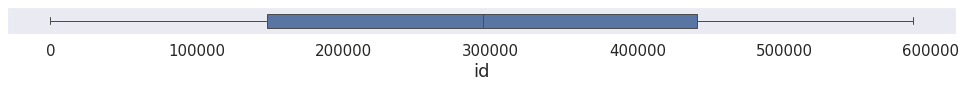

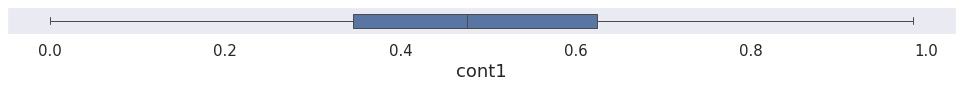

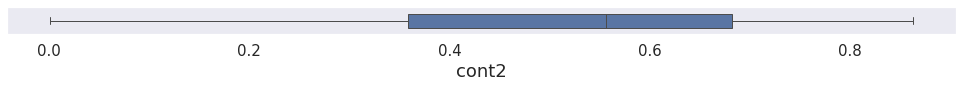

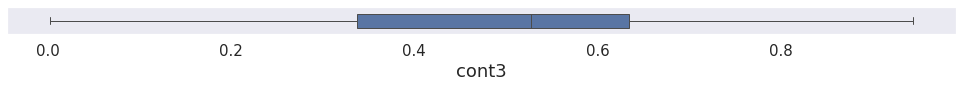

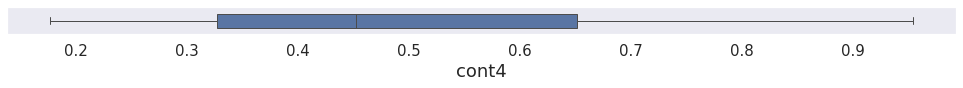

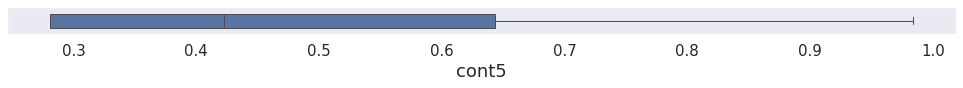

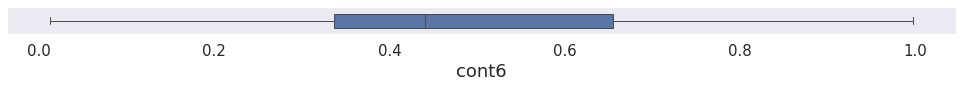

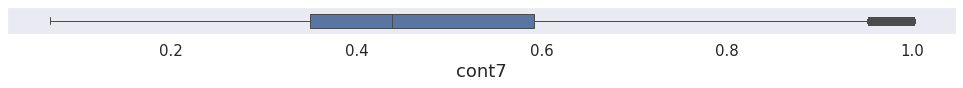

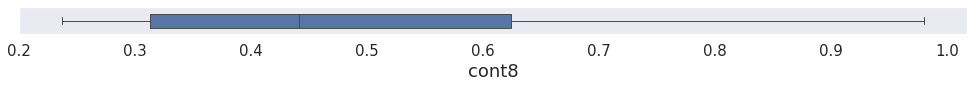

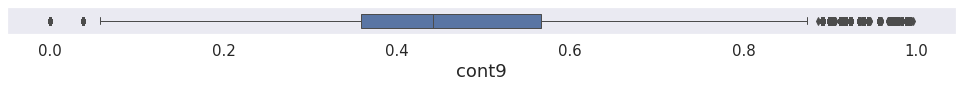

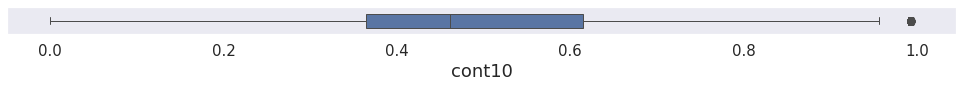

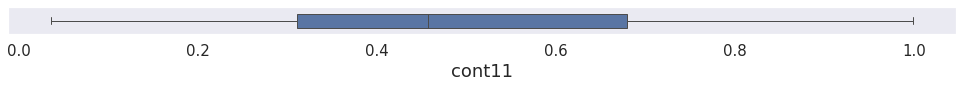

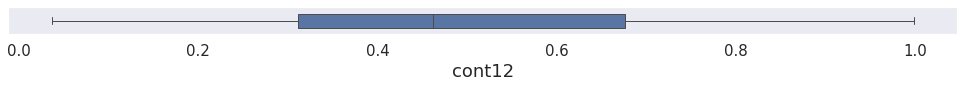

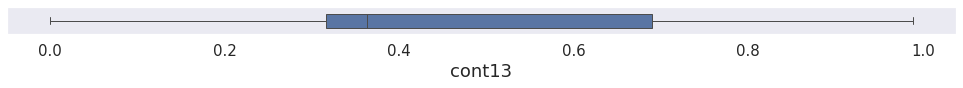

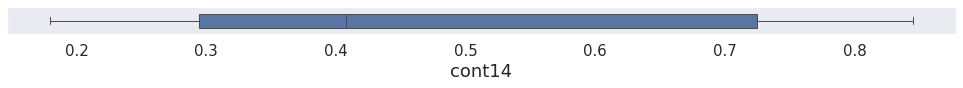

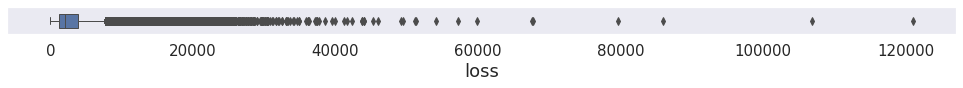

In [236]:
show_boxplot(df_train, *list_numerical_col)

---

## Data Visualization

- Continuous feature
 - Visualize data continuos
 - Correlation data continuos
 - Matrix correlation: continuous features
- Categorical feature
 - Transform categorical feature
 - Visualize data categorical
 - Matrix correlation: categorical features

In [237]:
# savefig()

def save_image(img: 'matplotlib',
               name: str,
               path: str = 'reports/images/'):
    
    fig = img.get_figure()
    fig.savefig(f"reports/images/{name}.png")
    
    return f"Image {name} saved."

#### PCA (Kernel Density Estimate)

In [161]:
### Preparing data to KDE

lable = df_train['loss'].values
dataset_visual = df_train.drop(['loss'], axis = 1)
dataset_visual = df_train[list_categorical_col].values
dataset_visual = StandardScaler().fit_transform(dataset_visual)

# import some data to play
X = dataset_visual
y = df_train['loss']

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

pca = PCA(n_components=3)
principalComponents  = pca.fit_transform(X)

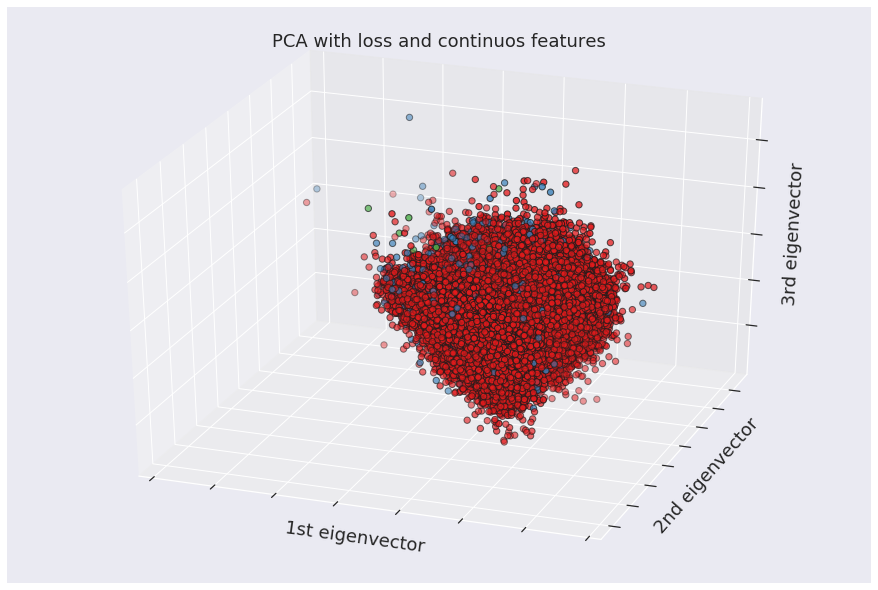

In [162]:
# Plotting a Kernel Density Estimate (KDE) with three PCA dimensions
fig3 = plt.figure(2, figsize=(12, 8))
ax2 = Axes3D(fig3, elev=-150, azim=70)
pca_img = ax2.scatter(principalComponents[:, 0],
                      principalComponents[:, 1], 
                      principalComponents[:, 2],
                      c=lable, 
                      cmap=plt.cm.Set1,
                      edgecolor='k', s=40)

ax2.set_title("PCA with loss and continuos features")
ax2.set_xlabel("1st eigenvector")
ax2.w_xaxis.set_ticklabels([])
ax2.set_ylabel("2nd eigenvector")
ax2.w_yaxis.set_ticklabels([])
ax2.set_zlabel("3rd eigenvector")
ax2.w_zaxis.set_ticklabels([])

plt.show()

In [163]:
print(pca.explained_variance_ratio_)

[0.05981928 0.04738145 0.04292431]


It is seen that the data are well grouped and presented in a PCA of 3 dimensions for each one of its components the variance of 5.97%, 4.73% and 4.29%, being a total of 14.99%.

In [164]:
save_image(img=pca_img, name='PCA')

'Image PCA saved.'

#### Data  Continuos Distribuition

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff523379048>,
      dtype=object)

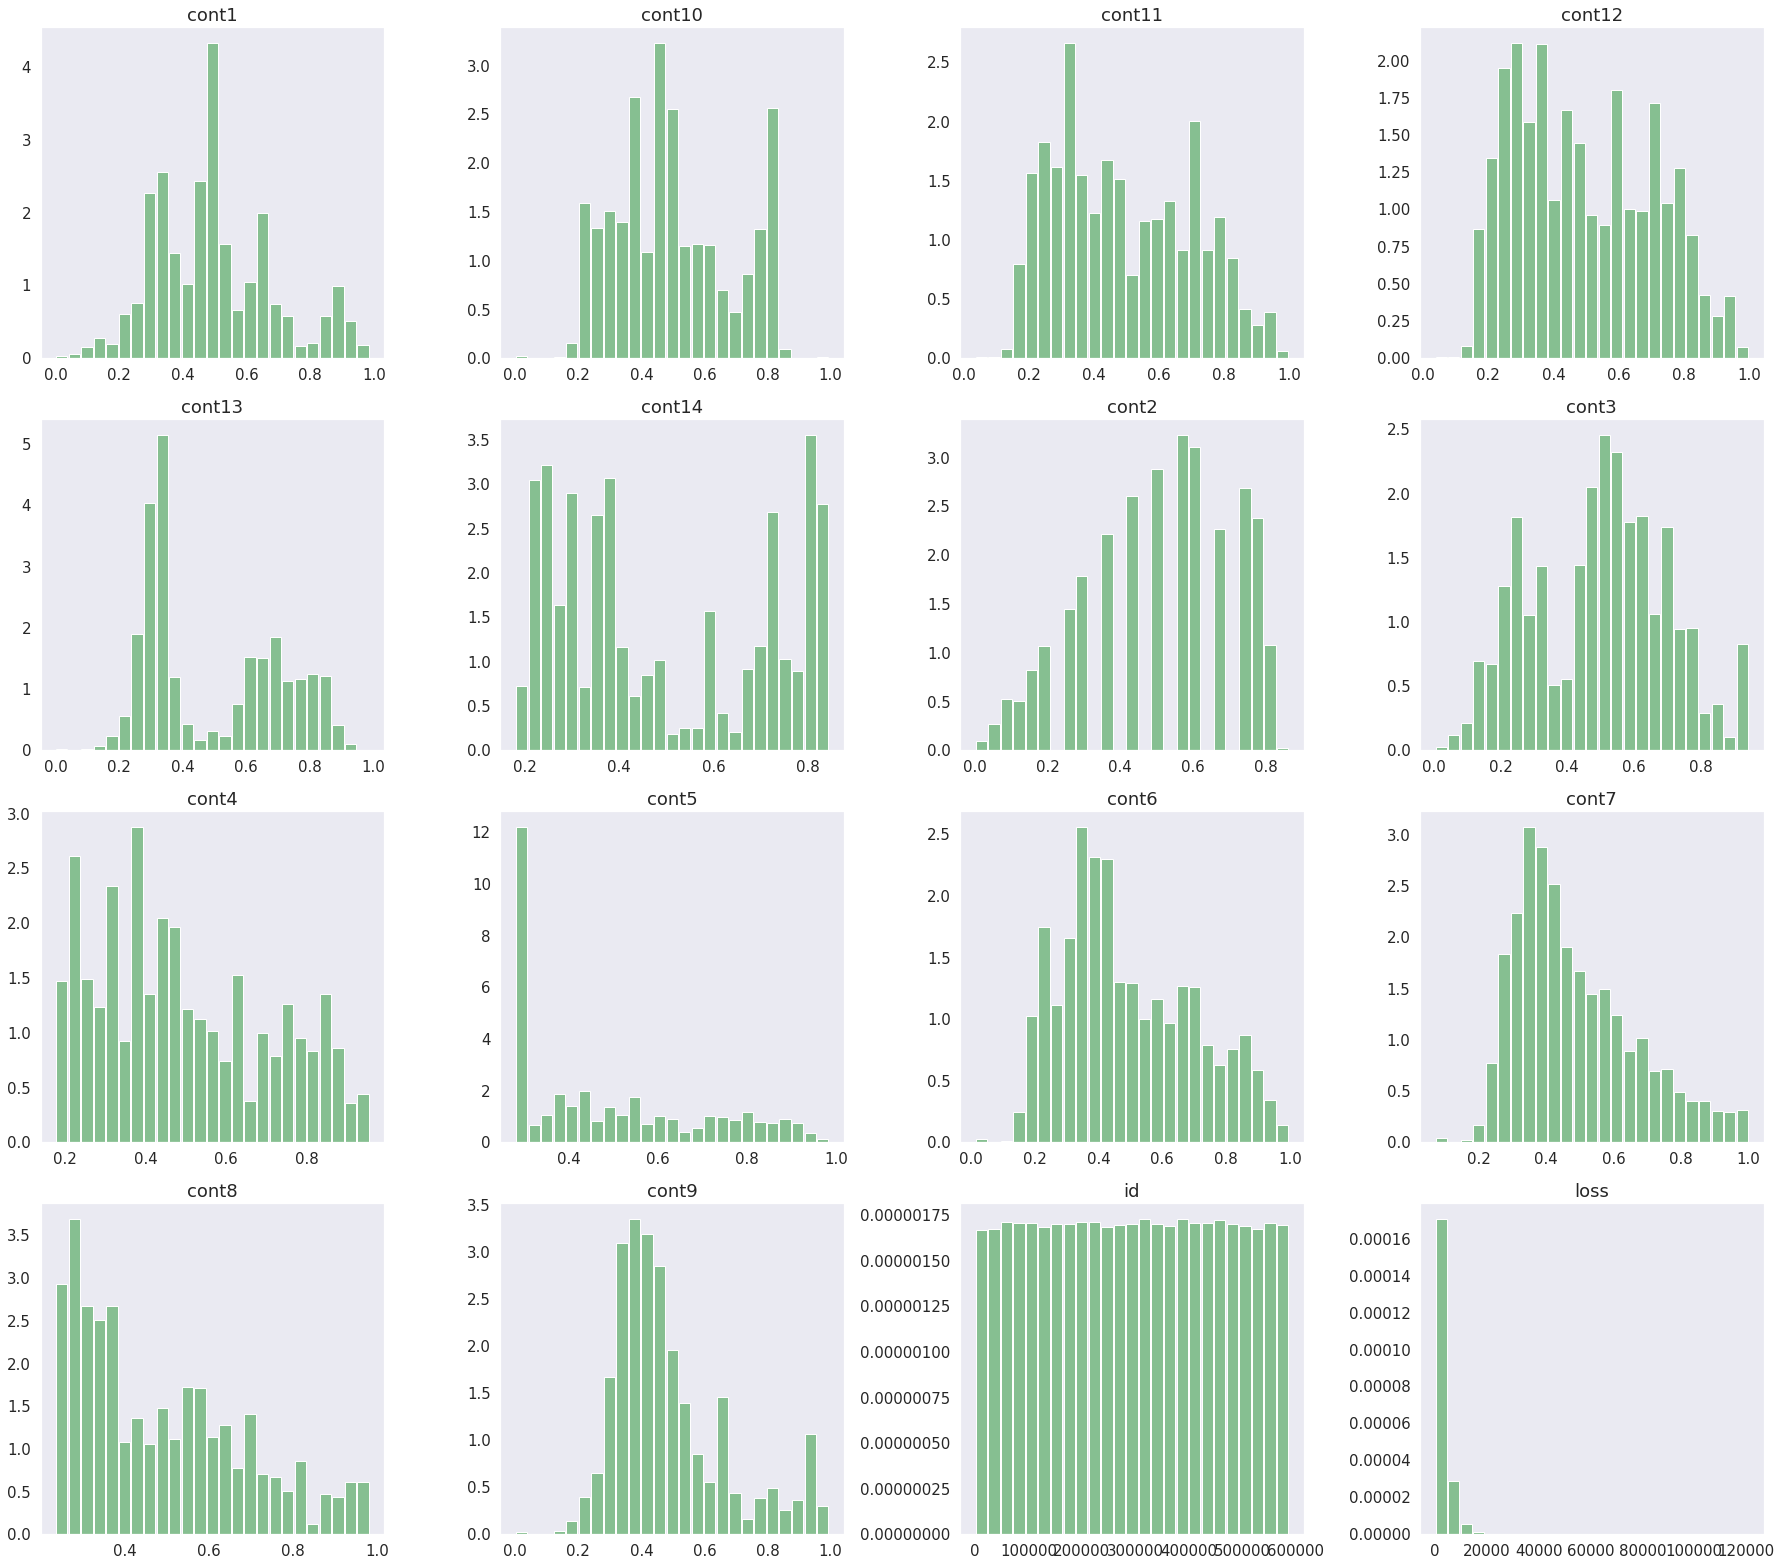

In [165]:
# the histogram of the data
df_train[list_numerical_col].hist(figsize=[25,22], 
                            density=True, 
                            bins=25, 
                            grid=False, 
                            color='#86bf91', 
                            zorder=2, 
                            rwidth=0.9)

#### Correlations

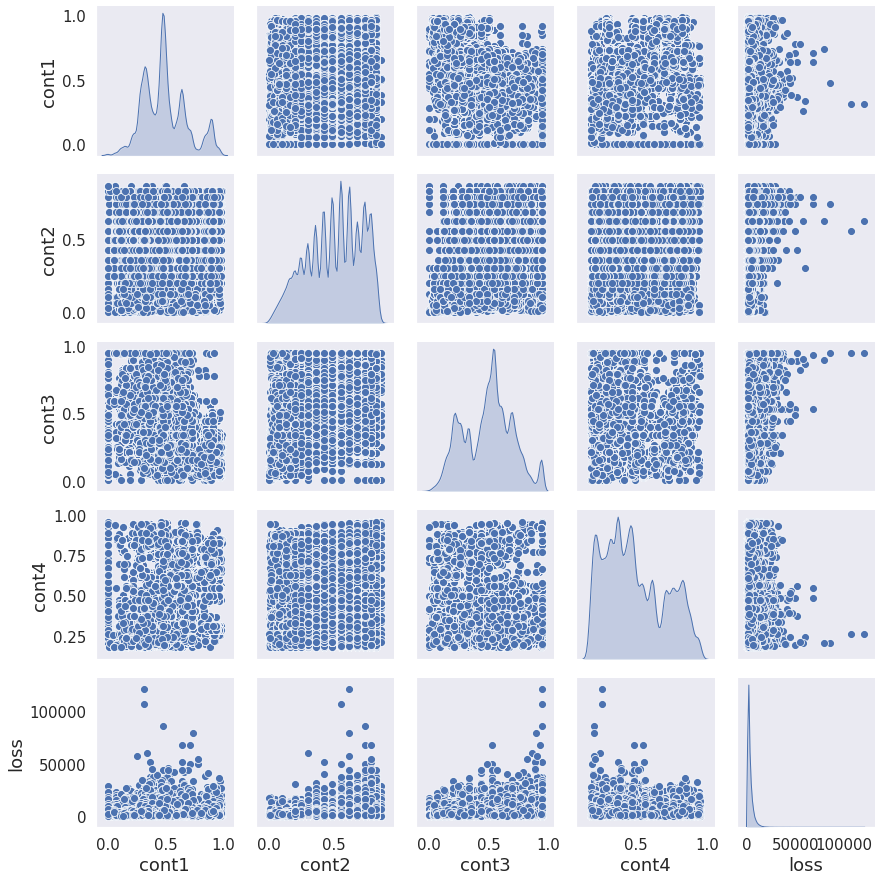

In [166]:
corr_cont_types_1_ate_4 = sns.pairplot(df_train[list_numerical_col],
                                       vars=['cont1',
                                             'cont2',
                                             'cont3',
                                             'cont4',
                                             'loss'],
                                       kind = 'scatter',
                                       diag_kind='kde')
print(corr_cont_types_1_ate_4)

In [167]:
# save image
fig = corr_cont_types_1_ate_4.fig.savefig("reports/images/corr_cont_types_1_ate_4.png")
print(f"Output (corr_cont_types_1_ate_4) saved.")

Output (corr_cont_types_1_ate_4) saved.


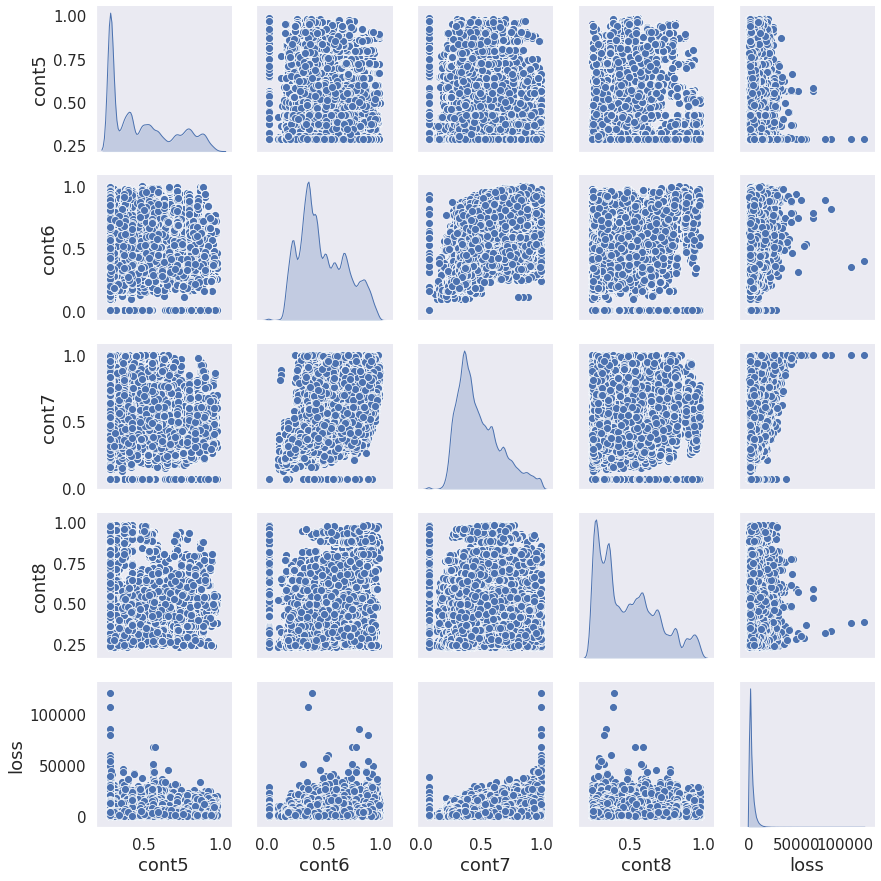

In [168]:
corr_cont_types_5_ate_8 = sns.pairplot(df_train[list_numerical_col],
                                       vars=['cont5',
                                             'cont6',
                                             'cont7',
                                             'cont8',
                                             'loss'],
                                       kind = 'scatter',
                                       diag_kind='kde')
print(corr_cont_types_5_ate_8)

In [169]:
# save image
fig = corr_cont_types_5_ate_8.savefig("reports/images/corr_cont_types_5_ate_8.png")
print(f"Output (corr_cont_types_5_ate_8) saved.")

Output (corr_cont_types_5_ate_8) saved.


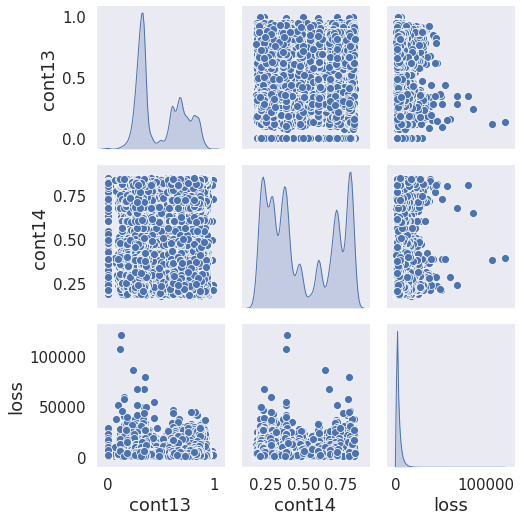

In [170]:
corr_cont_types_13_ate_14 = sns.pairplot(df_train[list_numerical_col],
                                        vars=['cont13',
                                              'cont14',
                                              'loss'],
                                        kind = 'scatter',
                                        diag_kind='kde')
print(corr_cont_types_13_ate_14)



In [171]:
# save image
fig = corr_cont_types_13_ate_14.savefig("reports/images/corr_cont_types_13_ate_14.png")
print(f"Output (corr_cont_types_13_ate_14) saved.")

Output (corr_cont_types_13_ate_14) saved.


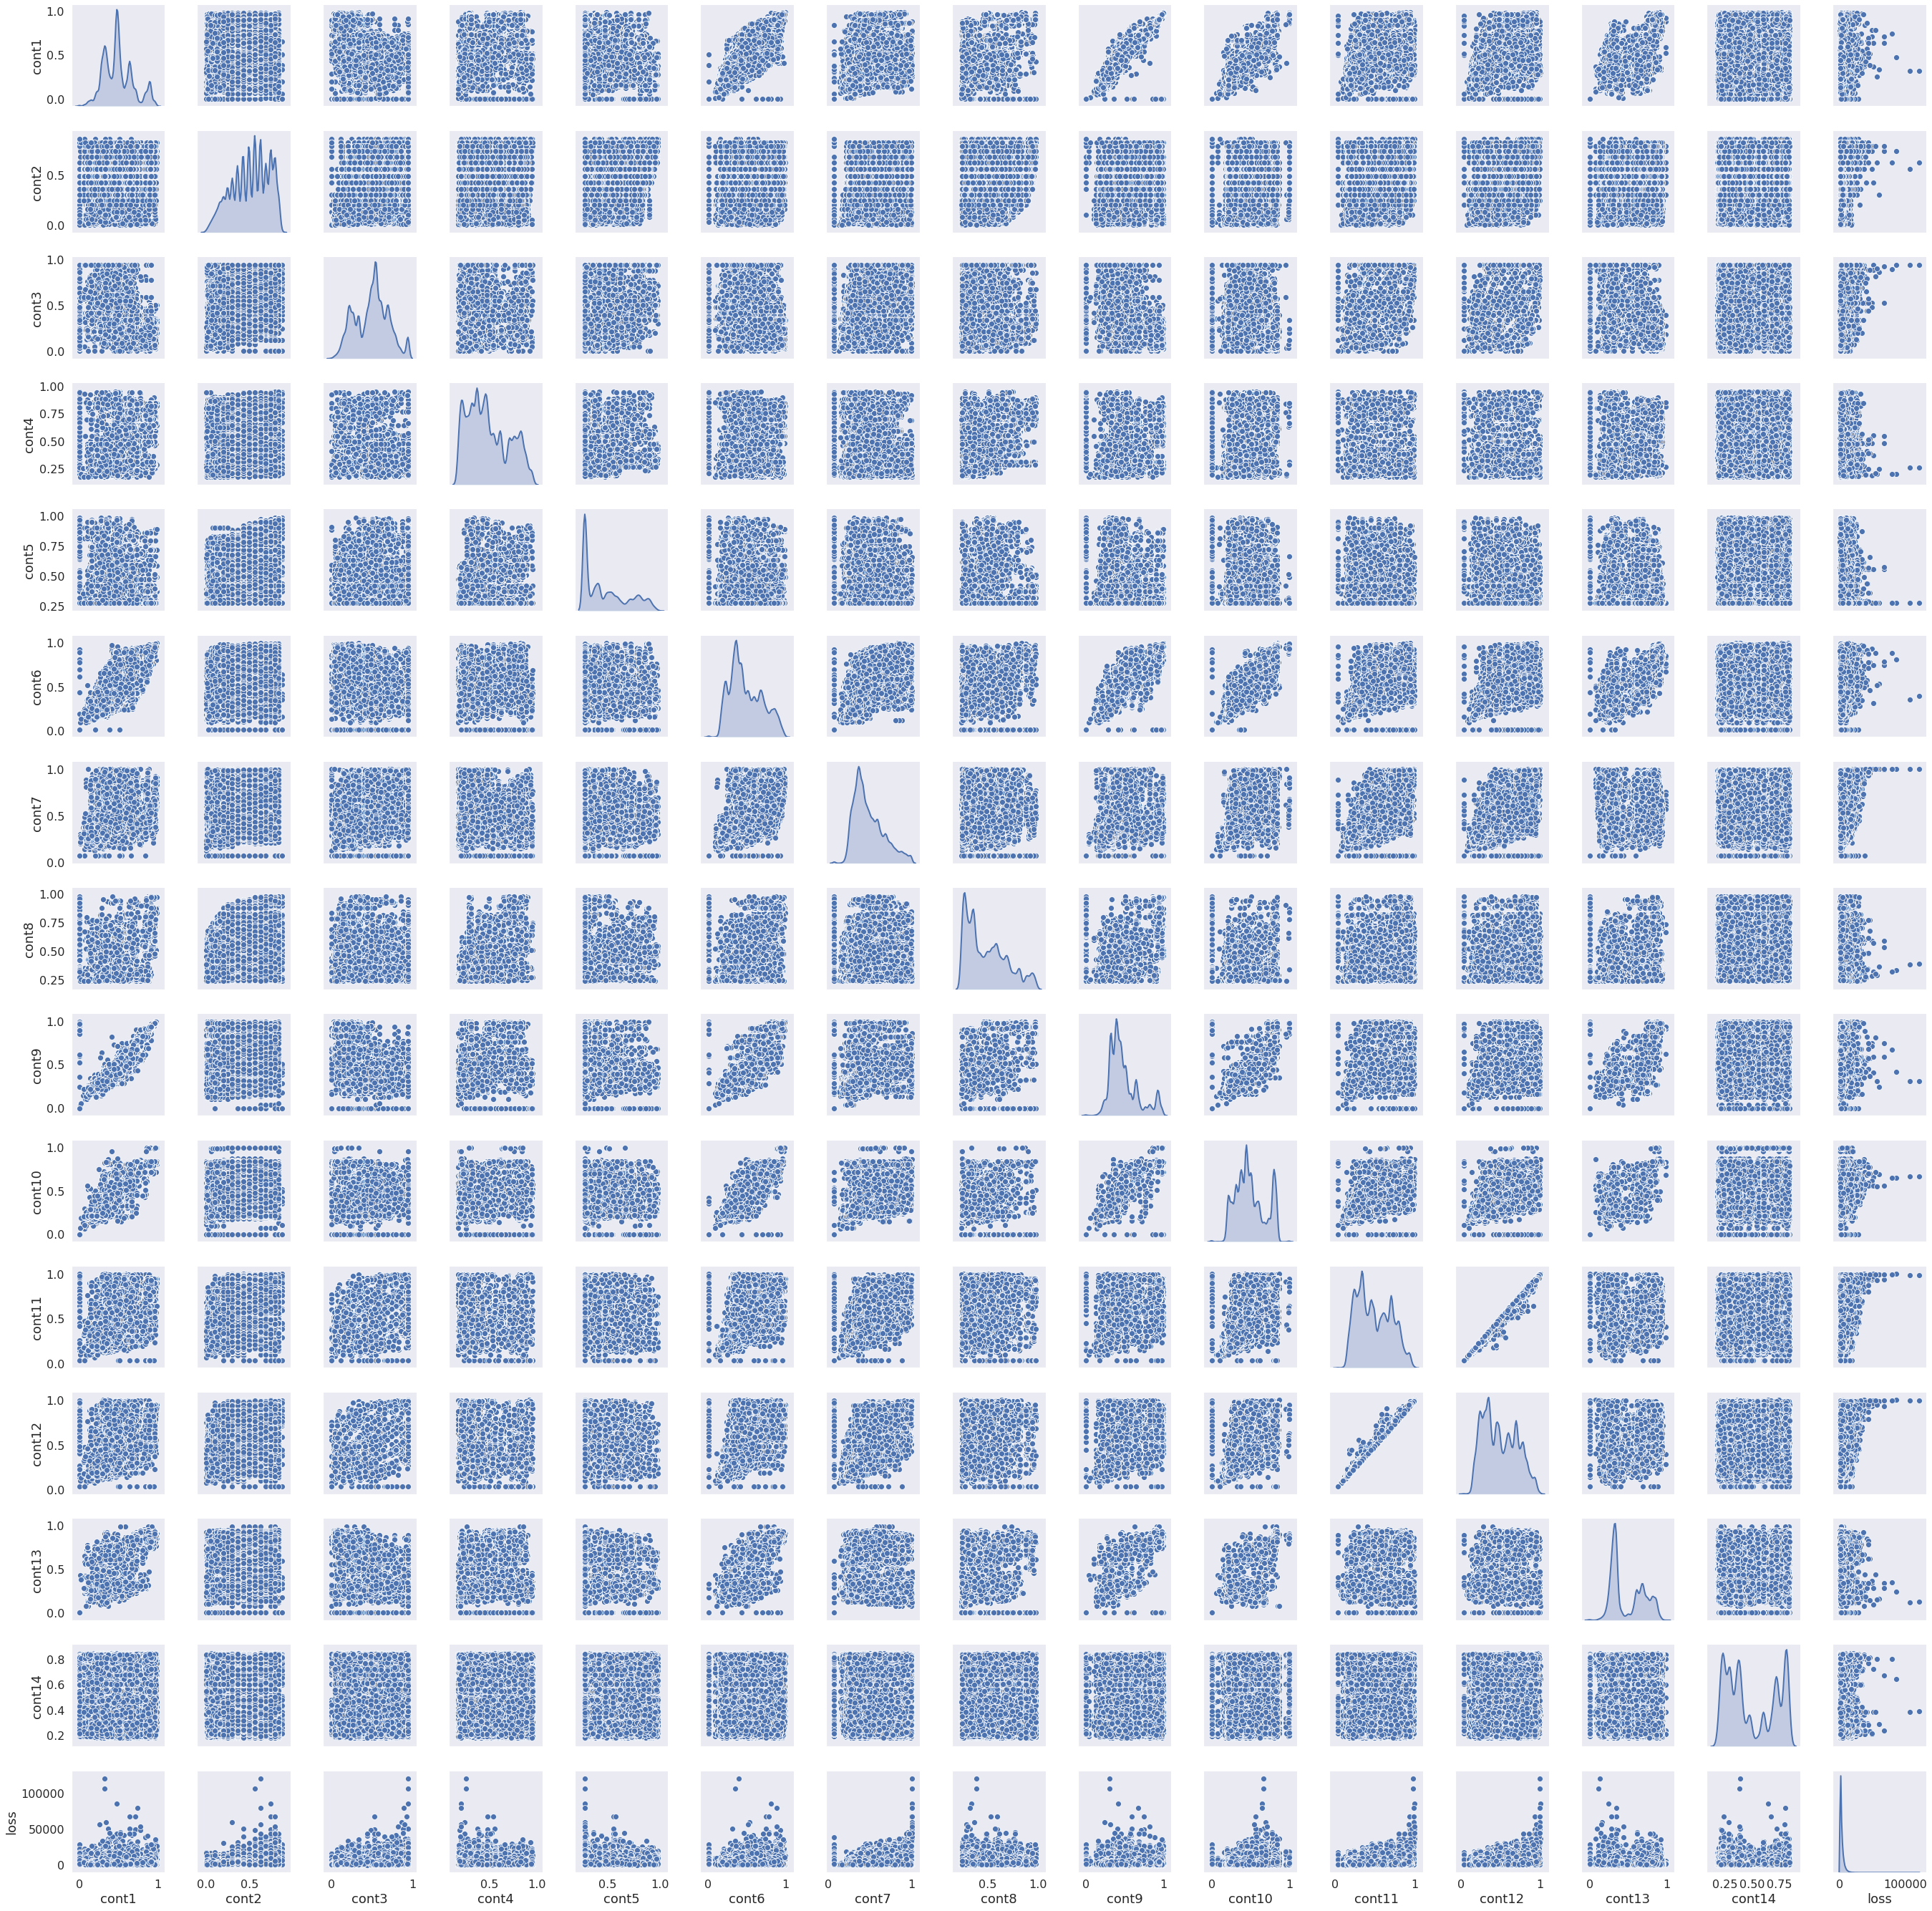

In [203]:
corr_cont_types_all = sns.pairplot(
    df_train[list_numerical_col],
    kind = 'scatter',
    diag_kind='kde')

In [204]:
# save image
fig = corr_cont_types_all.savefig("reports/images/corr_cont_types_all.png")
print(f"Output (corr_cont_types_all) saved.")

Output (corr_cont_types_all) saved.


### Matrix correlation: continuous features

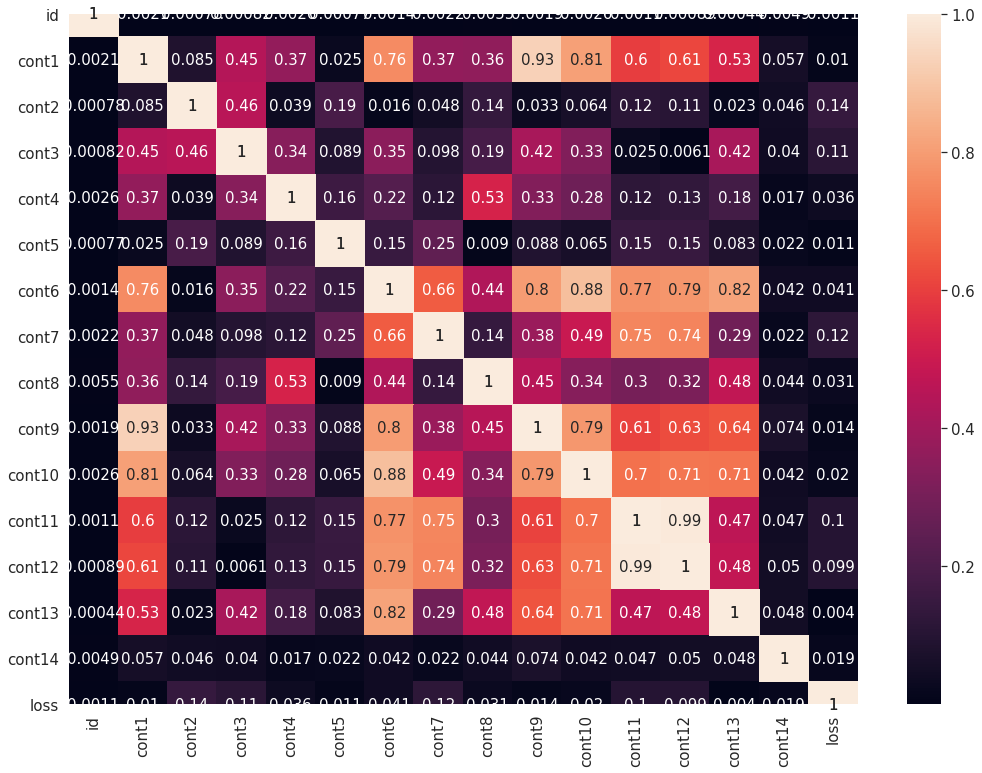

In [172]:
correlationMatrix = df_train[list_numerical_col].corr().abs()

plt.subplots(figsize=(18, 11))
plt.tight_layout() # save images without cut

sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
corr_matrix_cont = sns.heatmap(correlationMatrix,
            mask=correlationMatrix < 1,
            cbar=False,
            linecolor='white',
            annot = True)
plt.show()

In [196]:
# save image
corr_matrix_cont.figure.savefig("reports/images/corr_matrix_cont.png")
print(f"Output (corr_matrix_cont) saved.")

Output (corr_matrix_cont) saved.


It`s possible see correlations exists between some of the continuous variables.
In this case, the correlations score between cont10 and cont11 is 0.7. 

### Categorical Features

#### Best Correlation

In [238]:
def top_corr(df: 'dataframe', list_col: 'list', n_corr: int = 20, corr_method: str = 'pearson') -> 'Series':
    corr_top_list = df[list_col].corr(method=corr_method).abs()

    s = corr_top_list.unstack()
    sortedSeries = s.sort_values(kind="quicksort",ascending=False)
    best_correlation = sortedSeries[sortedSeries != 1.0][0:n_corr]

    print("-"*25, "TOP CORRELATED IN PAIRS", "-"*25, end='\n\n')
    return best_correlation

In [239]:
top_corr(df=df_train,
         list_col=list_categorical_col)

------------------------- TOP CORRELATED IN PAIRS -------------------------



cat3    cat90    0.96
cat90   cat3     0.96
cat7    cat89    0.96
cat89   cat7     0.96
cat2    cat9     0.93
cat9    cat2     0.93
cat6    cat50    0.93
cat50   cat6     0.93
cat116  cat104   0.92
cat104  cat116   0.92
cat8    cat102   0.90
cat102  cat8     0.90
cat98   cat86    0.89
cat86   cat98    0.89
cat66   cat8     0.86
cat8    cat66    0.86
cat115  cat86    0.85
cat86   cat115   0.85
cat111  cat4     0.83
cat4    cat111   0.83
dtype: float64

#### Without Correlation

In [240]:
def get_without_correlation(df, list_col, target_col):
    corr_list = df[list_col].corr().abs()

    s = corr_list.unstack()
    sorted_series = s\
                    .sort_values(kind="quicksort",ascending=True)\
                        .get(target_col)

    if sorted_series is None:
        print('All columns have correlation with target column.')
        return None
    
    without_correlation = sorted_series[sorted_series < 0.1][0:-1]

    print("-"*25, "WITHOUT CORRELATED WITH TARGET", "-"*25, end='\n\n')
    print(without_correlation)
    return without_correlation.index.tolist()

In [241]:
list_without_corr = get_without_correlation(df = df_train,
                                            list_col = list_categorical_col,
                                            target_col = df_train['loss'])

All columns have correlation with target column.


### Numerical Features

#### Best Correlation

In [242]:
top_corr(df=df_train,
         list_col=list_numerical_col)

------------------------- TOP CORRELATED IN PAIRS -------------------------



cont12  cont11   0.99
cont11  cont12   0.99
cont9   cont1    0.93
cont1   cont9    0.93
cont6   cont10   0.88
cont10  cont6    0.88
cont13  cont6    0.82
cont6   cont13   0.82
cont1   cont10   0.81
cont10  cont1    0.81
cont9   cont6    0.80
cont6   cont9    0.80
cont10  cont9    0.79
cont9   cont10   0.79
cont12  cont6    0.79
cont6   cont12   0.79
cont11  cont6    0.77
cont6   cont11   0.77
        cont1    0.76
cont1   cont6    0.76
dtype: float64

#### Without Correlation

In [243]:
list_without_corr = get_without_correlation(df=df_train,
                                            list_col=list_numerical_col,
                                            target_col='loss')

------------------------- WITHOUT CORRELATED WITH TARGET -------------------------

id       0.00
cont13   0.00
cont1    0.01
cont5    0.01
cont9    0.01
cont14   0.02
cont10   0.02
cont8    0.03
cont4    0.04
cont6    0.04
cont12   0.10
dtype: float64


---

## Feature Importance

In [244]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=20):
    """
    Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
    """
     
    imp_dict = dict(zip(column_names, feature_importances))
    
    # get name features sorted
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    # get values
    top_importances = [imp_dict[feature] for feature in top_features]
    
    # create dataframe with feature_importance
    df = pd.DataFrame(data={'feature': top_features, 'importance': top_importances})
    return df

In [245]:
list_columns.remove('loss')

In [246]:
df_train[list_columns].head()

id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  cat11  \
0   1     0     1     0     1     0     0     0     0     1      0      1   
1   2     0     1     0     0     0     0     0     0     1      1      0   
2   5     0     1     0     0     1     0     0     0     1      1      1   
3  10     1     1     0     1     0     0     0     0     1      0      0   
4  11     0     1     0     1     0     0     0     0     1      1      0   

   cat12  cat13  cat14  cat15  cat16  cat17  cat18  cat19  cat20  cat21  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      1      1      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      1      0      0      0      0      0      0      0      0      0   

   cat22  cat23  cat24  cat25  cat26  cat27  cat28  cat29  cat30  cat31  \
0      0      1      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      1      0      0      0      0      0      0      0      0   
4      0      1      0      0      0      0      0      0      0      0   

   cat32  cat33  cat34  cat35  cat36  cat37  cat38  cat39  cat40  cat41  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      1      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat42  cat43  cat44  cat45  cat46  cat47  cat48  cat49  cat50  cat51  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat52  cat53  cat54  cat55  cat56  cat57  cat58  cat59  cat60  cat61  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat62  cat63  cat64  cat65  cat66  cat67  cat68  cat69  cat70  cat71  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   cat72  cat73  cat74  cat75  cat76  cat77  cat78  cat79  cat80  cat81  \
0      0      0      0      1      0      3      1      1      3      3   
1      0      0      0      0      0      3      1      1      3      3   
2      0      0      0      0      0      3      1      1      1      3   
3      0      1      0      0      0      3      1      1      3      3   
4      1      0      0      0      0      3      1      3      1      3   

   cat82  cat83  cat84  cat85  cat86  cat87  cat88  cat89  cat90  cat91  \
0      1      3      2      1      3      1      0      0      0      0   
1      0      1      2      1      3      1      0      0      0      0   
2      1      3      2      1      1      1      0      0      0      0   
3      3      1      2      1      3      1      0      0      0      0   
4      1

In [247]:
# create model

rf = RandomForestRegressor(n_estimators=df_train.shape[1], # numbers tree
                            max_depth=8,
                            min_samples_leaf=df_train.shape[1],
                            max_features=0.2, # each tree utility 20% in the features
                            n_jobs=-1)

In [248]:
# trainning model

rf.fit(df_train[list_columns], df_train['loss'])

features = df_train[list_columns].columns.values

print("---Traing Done---")

---Traing Done---


In [249]:
# get trained model (rf) and avalible the feature_importance
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

# print feature_importance in the rf randomForest
display(feature_importance)

feature  importance
0    cat80        0.24
1    cat79        0.20
2    cat87        0.06
3    cat57        0.06
4    cat12        0.05
5   cat101        0.04
6    cont2        0.04
7     cat7        0.04
8    cont7        0.03
9    cat81        0.03
10   cat89        0.03
11  cont12        0.02
12  cont11        0.02
13   cat72        0.01
14   cat10        0.01
15    cat1        0.01
16   cont3        0.01
17  cat103        0.01
18   cat94        0.01
19    cat2        0.01

[Text(0, 0.5, 'Importance'),
 Text(0.5, 0, "Name's Variable"),
 Text(0.5, 1.0, 'Variable Importances')]

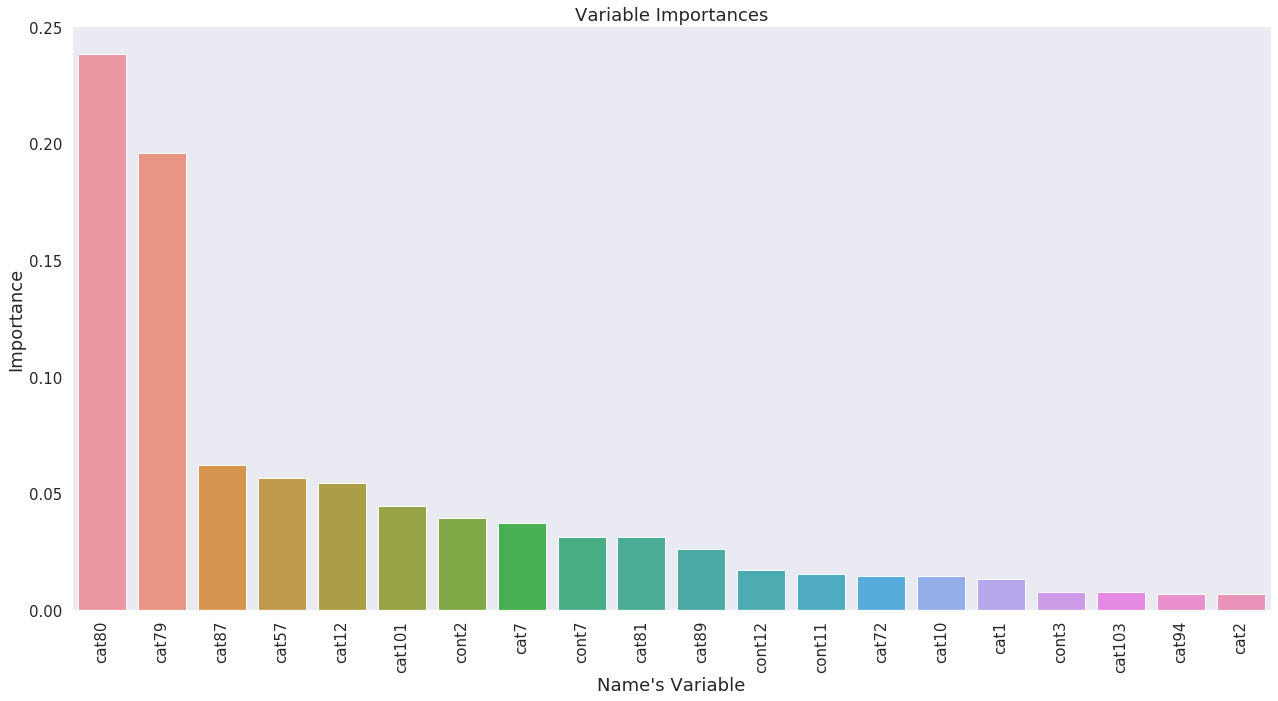

In [250]:
fig,ax = plt.subplots()
plt.xticks(rotation='vertical')

fig.set_size_inches(18,10)
sns.barplot(data=feature_importance[:20], 
            x="feature", 
            y="importance", 
            ax=ax)
ax.set(xlabel="Name's Variable",
       ylabel='Importance',
       title="Variable Importances")

### Drop Feature Without Importance and Without Correlation

In [251]:
def get_without_importance(df_feature_importance: 'dataframe') -> list:
    list_drop_col = []
              
    cond_duracao = (df_feature_importance['importance'] < 0.01)
    df_temp = df_feature_importance[cond_duracao]
    
    list_drop_col = df_temp['feature'].tolist()
    
    print("-"*25, "FEATURE WITHOUT IMPORTANCE", "-"*25, end='\n\n')
    print(df_temp)
    return list_drop_col

In [252]:
def remove_without_importace(df: 'dataframe', list_without_imp: list) -> int:
    print(f'Columns before = {df.shape[1]}')
    
    for column in list_without_imp:
        del df[column]
        
    return print(f"Columns after = {df.shape[1]}")

In [253]:
def remove_without_corr(df: 'dataframe', list_without_corr: list) -> int:
    print(f'Columns before = {df.shape[1]}')

    for column in list_without_corr:
        del df[column]
    
    return print(f"Columns after = {df.shape[1]}")

In [254]:
remove_without_corr(df_train, list_without_corr)

Columns before = 132
Columns after = 121


In [255]:
list_without_importance = get_without_importance(df_feature_importance = feature_importance)

------------------------- FEATURE WITHOUT IMPORTANCE -------------------------

   feature  importance
16   cont3        0.01
17  cat103        0.01
18   cat94        0.01
19    cat2        0.01


In [256]:
remove_without_importace(df = df_train,
                        list_without_imp = list_without_importance)

Columns before = 121
Columns after = 117


In [257]:
list_numerical_col = get_col(df=df_train,
                             type_descr=np.number)
list_categorical_col = get_col(df=df_train,
                               type_descr=np.object)
list_columns = get_col(df=df_train,
                       type_descr=[np.object, np.number])

Dataframe not contains <class 'object'> columns !


---

## Storage Data Cleaning

In [258]:
def save_data_clenning(df: 'dataframe' = None,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "Data storage!"

In [259]:
save_data_clenning(df = df_train,
                   path = 'data/cleansing/train.csv')

save_data_clenning(df = df_test,
                   path = 'data/cleansing/test.csv')

'Data storage!'